In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock, compute_comethylation
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, mutation_features, methylation_pred

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

In [3]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/030623_output"
dependency_f_dir = "/cellar/users/zkoch/methylation_and_mutation/dependency_files"
data_dir = "/cellar/users/zkoch/methylation_and_mutation/data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
#methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/processed_methylation'
icgc_dir = "/cellar/users/zkoch/methylation_and_mutation/data/icgc"

# TCGA

### Get data

In [4]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv")
    )
# read in other already computed files
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


# ICGC

### Get data

In [5]:
icgc_mut_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_mut_df.parquet")
icgc_meta_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_meta_df.parquet")
illumina_cpg_locs_df = get_data.get_illum_locs(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"))
icgc_methyl_dd = dd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/icgc/methyl_dir')
icgc_methyl_df = icgc_methyl_dd.compute()
icgc_methyl_df_t = icgc_methyl_df.T
shared_samples = set(icgc_methyl_df_t.index) & set(icgc_mut_df['sample'].unique()) & set(icgc_meta_df['sample'].unique())
icgc_methyl_df_t = icgc_methyl_df_t.loc[shared_samples]
icgc_methyl_df_t.dropna(how = 'any', axis=1, inplace=True)
icgc_mi_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/icgc_mi.parquet')
icgc_mi_df.sort_values(by='mutual_info', ascending=False, inplace=True)

In [5]:
icgc_meta_df['dataset'].value_counts()

PRAD-CA    241
PACA-AU    167
OV-AU       93
PBCA-DE     74
CLLE-ES     55
PAEN-AU     22
UTCA-FR     17
PRAD-UK      3
Name: dataset, dtype: int64

In [6]:
# rename columns 
icgc_mut_df.rename(columns={'chromosome':'chr', 'sample': 'case_submitter_id', 'chromosome_start':'start', 'MAF': 'DNA_VAF'}, inplace=True)
icgc_meta_df.rename(columns={'sample': 'case_submitter_id'}, inplace=True)
# merge with mut
icgc_mut_w_age_df = icgc_mut_df.merge(icgc_meta_df, on='case_submitter_id', how='left')
# and methyl dfs
icgc_meta_df_to_merge = icgc_meta_df[['case_submitter_id', 'age_at_index', 'dataset', 'gender']]
icgc_meta_df_to_merge.set_index('case_submitter_id', inplace=True)
# make gender column uppercase
icgc_meta_df_to_merge['gender'] = icgc_meta_df_to_merge['gender'].str.upper()
icgc_methyl_age_df_t = icgc_methyl_df_t.merge(icgc_meta_df_to_merge, left_index=True, right_index=True, how='left')

/tmp/ipykernel_613811/2635062645.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icgc_meta_df_to_merge['gender'] = icgc_meta_df_to_merge['gender'].str.upper()


<AxesSubplot:>

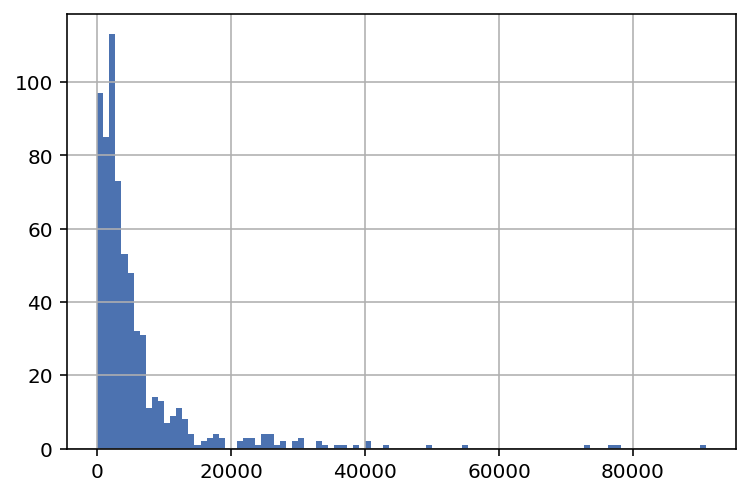

In [9]:
icgc_mut_w_age_df['case_submitter_id'].value_counts().hist(bins =100)

# Mutation features

#### Development

In [5]:
godmc_meqtls = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/meQTL/goDMC_meQTL/goDMC_meQTLs_for_mutClock.parquet')

In [ ]:
matrix_qtl_dir_new = '/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/clumped_muts_CV'
new_qtl = pd.read_parquet(os.path.join(matrix_qtl_dir_new, 'chr19_meqtl_fold_2.parquet'))
new_qtl1 = pd.read_parquet(os.path.join(matrix_qtl_dir_new, 'chr18_meqtl_fold_1.parquet'))


In [372]:
mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, meqtl_db = godmc_meqtls, out_dir = out_dir, 
    consortium = 'TCGA', dataset = 'SKCM', cross_val_num = 0,
    matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/clumped_muts_CV"
    )

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [ ]:
age_corr = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'])
age_corr.drop(['age_at_index', 'gender_MALE', 'gender_FEMALE'], inplace=True)
age_corr = age_corr.to_frame()
age_corr.columns = ['age_corr']

methyl_stdev = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, :].std()
methyl_stdev.drop(['age_at_index', 'gender_MALE', 'gender_FEMALE'], inplace=True)
methyl_stdev = methyl_stdev.to_frame()
methyl_stdev.columns = ['methyl_stdev']

cpg_pred_priority_corr = mut_feat.choose_cpgs_to_train(metric_df = age_corr, bin_size = 50000, sort_by=['age_corr', 'count'], mean = True)

cpg_pred_priority_corr_stdev = cpg_pred_priority_corr.merge(methyl_stdev, left_on = '#id', right_index=True, how='left')
cpg_pred_priority_corr_stdev['abs_age_corr'] = cpg_pred_priority_corr_stdev['age_corr'].abs()

# sort by count
cpg_pred_priority_corr_stdev.sort_values(by=['count', 'abs_age_corr'], ascending=False, inplace=True)

In [396]:
cpg_pred_priority_corr_stdev.loc[cpg_pred_priority_corr_stdev['count'] > 0]

,#id,chr,start,Strand,rounded_start,count,bin_edge_l,age_corr,methyl_stdev,abs_age_corr
213876,cg12583591,19,9092130,R,9050000,3.837209,9050000.0,-0.029259,0.188524,0.029259
133049,cg02391549,19,9091983,R,9050000,3.837209,9050000.0,0.025670,0.238067,0.025670
187822,cg15811371,19,9093198,R,9050000,3.837209,9050000.0,-0.009182,0.109805,0.009182
161333,cg05222216,19,9093098,F,9050000,3.837209,9050000.0,0.008320,0.201559,0.008320
38065,cg12541127,2,179641543,R,179600000,2.257042,179600000.0,0.097112,0.253617,0.097112
...,...,...,...,...,...,...,...,...,...,...
175608,cg16524762,1,40627076,R,40600000,0.003311,40600000.0,-0.000867,0.003595,0.000867
173736,cg00395931,1,2158622,R,2150000,0.003311,2150000.0,0.000357,0.012635,0.000357
174748,cg15997770,1,8716182,R,8700000,0.003311,8700000.0,-0.000318,0.078422,0.000318
174061,cg12302527,1,3461381,R,3450000,0.003311,3450000.0,0.000125,0.196496,0.000125


SpearmanrResult(correlation=0.19141451006006663, pvalue=0.0)

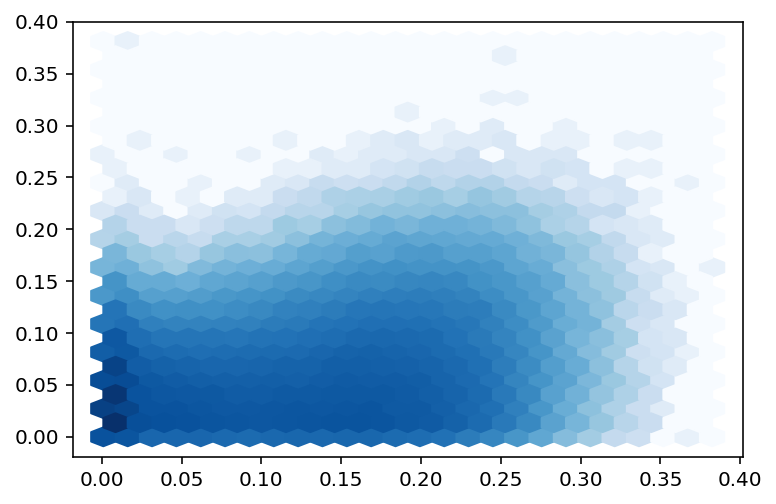

In [383]:
plt.hexbin(cpg_pred_priority_corr_stdev['methyl_stdev'], np.abs(cpg_pred_priority_corr_stdev['age_corr']), gridsize=25, cmap='Blues', bins = 'log')
spearmanr(cpg_pred_priority_corr_stdev['methyl_stdev'], np.abs(cpg_pred_priority_corr_stdev['age_corr']))

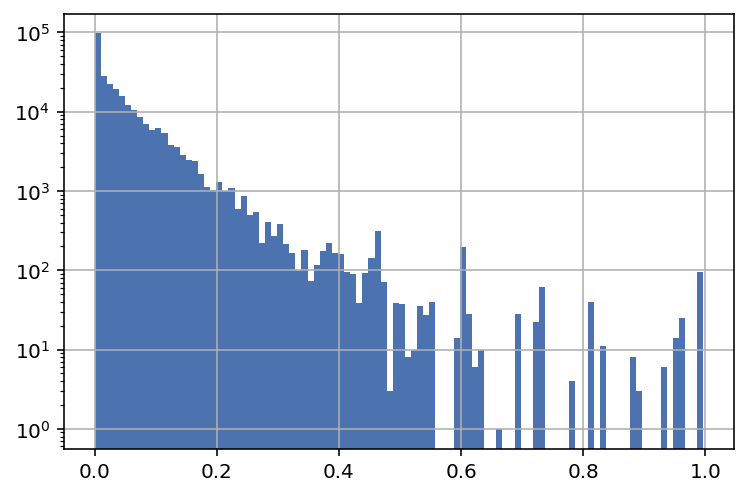

In [391]:
cpg_pred_priority_corr_stdev.loc[cpg_pred_priority_corr_stdev['count'] < 1, 'count'].hist(bins=100)
plt.yscale('log')

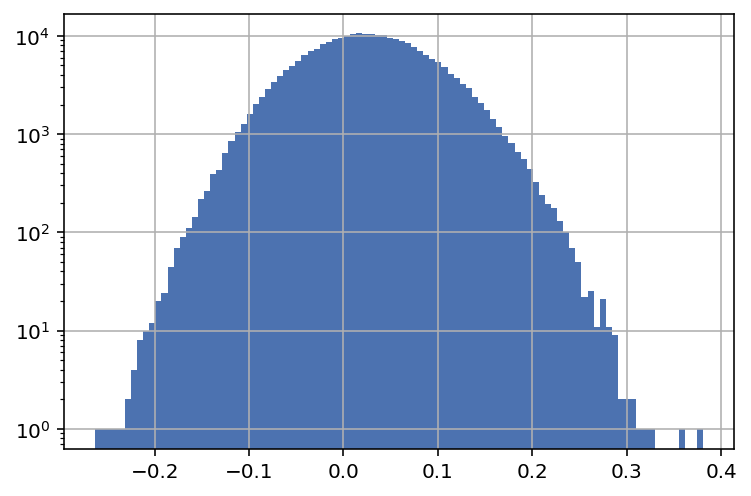

In [393]:
cpg_pred_priority_corr_stdev.loc[cpg_pred_priority_corr_stdev['count'] > -1, 'age_corr'].hist(bins=100)
plt.yscale('log')

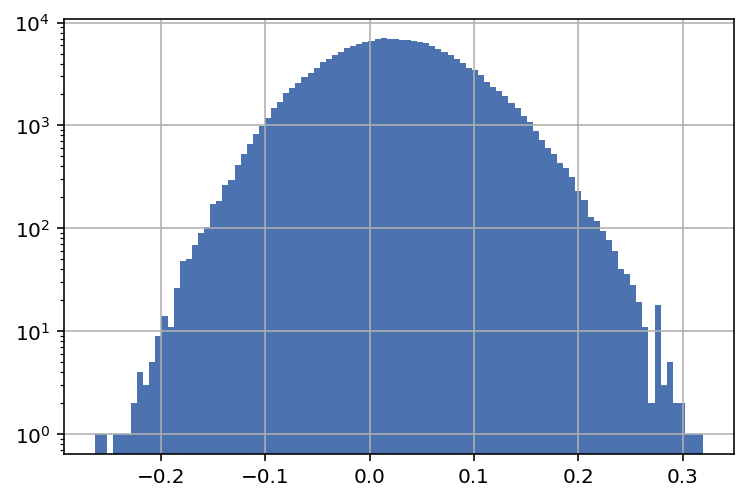

In [394]:
cpg_pred_priority_corr_stdev.loc[cpg_pred_priority_corr_stdev['count'] > 0, 'age_corr'].hist(bins=100)
plt.yscale('log')

SpearmanrResult(correlation=-0.0373865725249191, pvalue=3.980271516620193e-83)

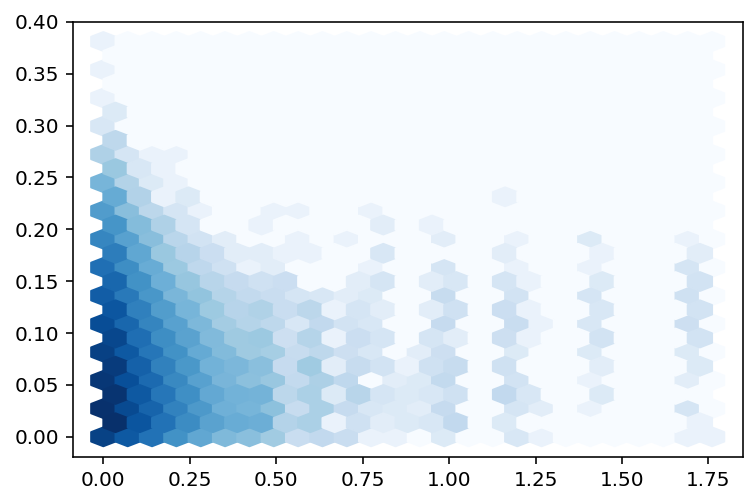

In [390]:
plt.hexbin(cpg_pred_priority_corr_stdev.loc[cpg_pred_priority_corr_stdev['count'] < 2, 'count'], np.abs(cpg_pred_priority_corr_stdev.loc[cpg_pred_priority_corr_stdev['count'] < 2, 'age_corr']), gridsize=25, cmap='Blues', bins = 'log')
spearmanr(cpg_pred_priority_corr_stdev.loc[cpg_pred_priority_corr_stdev['count'] < 2, 'count'], np.abs(cpg_pred_priority_corr_stdev.loc[cpg_pred_priority_corr_stdev['count'] < 2, 'age_corr']))

In [373]:
mut_feat.create_all_feat_mats(
    cpg_ids = cpg_pred_priority_corr_stdev.iloc[11:13]['#id'].values,
    aggregate = 'Both')

Finished 0 of 2
Finished 1 of 2


In [374]:
mut_feat.out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/030923_output"
mut_feat.save_mutation_features(start_top_cpgs = 0)

Saved mutation features to
/cellar/users/zkoch/methylation_and_mutation/output_dirs/030923_output/TCGA_SKCM_50correl_100meqtl_50000nearby_Bothagg_2numCpGs_0startTopCpGs_500maxDBsites_250extendAmount_0crossValNum/TCGA_SKCM_50correl_100meqtl_50000nearby_Bothagg_2numCpGs_0startTopCpGs_500maxDBsites_250extendAmount_0crossValNum.features.pkl


'/cellar/users/zkoch/methylation_and_mutation/output_dirs/030923_output/TCGA_SKCM_50correl_100meqtl_50000nearby_Bothagg_2numCpGs_0startTopCpGs_500maxDBsites_250extendAmount_0crossValNum/TCGA_SKCM_50correl_100meqtl_50000nearby_Bothagg_2numCpGs_0startTopCpGs_500maxDBsites_250extendAmount_0crossValNum.features.pkl'

In [375]:
mut_pred = methylation_pred.methylationPrediction(
    model_type = 'elasticNet',
    scramble = False,
    mut_feat_store_fns = ['/cellar/users/zkoch/methylation_and_mutation/output_dirs/030923_output/TCGA_SKCM_50correl_100meqtl_50000nearby_Bothagg_2numCpGs_0startTopCpGs_500maxDBsites_250extendAmount_0crossValNum/TCGA_SKCM_50correl_100meqtl_50000nearby_Bothagg_2numCpGs_0startTopCpGs_500maxDBsites_250extendAmount_0crossValNum.features.pkl']
    )
mut_pred.train_all_models(only_agg=False)
mut_pred.apply_all_models(only_agg=False)

Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/030923_output/TCGA_SKCM_50correl_100meqtl_50000nearby_Bothagg_2numCpGs_0startTopCpGs_500maxDBsites_250extendAmount_0crossValNum/TCGA_SKCM_50correl_100meqtl_50000nearby_Bothagg_2numCpGs_0startTopCpGs_500maxDBsites_250extendAmount_0crossValNum.features.pkl
done 0 CpGs of 2
done 1 CpGs of 2
Predicted methylation for 0 CpGs of 2


In [376]:
mut_pred.save_models_and_preds()

wrote out trained models, predictions, and performances to /cellar/users/zkoch/methylation_and_mutation/output_dirs/030923_output/TCGA_SKCM_50correl_100meqtl_50000nearby_Bothagg_2numCpGs_0startTopCpGs_500maxDBsites_250extendAmount_0crossValNum


In [359]:
mut_pred.trained_models['cg12541127'].feature_names_in_[mut_pred.trained_models['cg12541127'].coef_ != 0]

array(['nearby', 'very_nearby', 'matrixqtl_neg_beta_ext', 'gender_FEMALE',
       'gender_MALE'], dtype=object)

In [360]:
mut_pred.trained_models['cg12541127'].coef_[mut_pred.trained_models['cg12541127'].coef_ != 0]

array([-0.00798231,  0.01856067, -0.26986357,  0.03457181, -0.00238845])

In [400]:
pd.read_parquet(os.path.join("/cellar/users/zkoch/methylation_and_mutation/output_dirs/030923_output/TCGA_SKCM_500correl_100000meqtl_50000nearby_Bothagg_10numCpGs_10startTopCpGs_26000maxDBsites_250extendAmount_0crossValNum", "methyl_predictions_elasticNet_Falsescramble.parquet"))

,cg09210514,cg06335867,cg16867657,cg08309135,cg12903574,cg14750263,cg09017434,cg13986294,cg13862384,cg07569216
TCGA-3N-A9WC,0.329935,0.399247,0.559952,0.691742,0.827822,0.245849,0.23401,0.45792,0.266547,0.602583
TCGA-BF-A1PU,0.169562,0.367021,0.540003,0.691742,0.793019,0.126251,0.23401,0.45792,0.057468,0.550767
TCGA-BF-A1PX,0.172829,0.395526,0.559952,0.691742,0.799987,0.130517,0.23401,0.45792,0.233086,0.595150
TCGA-BF-A1PZ,0.133186,0.386444,0.540003,0.691742,0.793019,0.087591,0.23401,0.45792,0.242851,0.550767
TCGA-BF-A1Q0,0.190081,0.399247,0.559952,0.691742,0.799987,0.142301,0.23401,0.45792,0.273628,0.607964
...,...,...,...,...,...,...,...,...,...,...
TCGA-XV-A9W5,0.175187,0.389535,0.559952,0.691742,0.799987,0.130137,0.23401,0.45792,0.154310,0.595150
TCGA-XV-AAZY,0.187662,0.386444,0.543000,0.691742,0.793019,0.136861,0.23401,0.45792,0.235604,0.550767
TCGA-YG-AA3O,0.195956,0.371964,0.559952,0.691742,0.799987,0.149161,0.23401,0.45792,0.198912,0.595150
TCGA-YG-AA3P,0.185508,0.386444,0.540003,0.691742,0.793019,0.138510,0.23401,0.45792,0.235604,0.550767


In [401]:
# read from pickle file
fn = os.path.join("/cellar/users/zkoch/methylation_and_mutation/output_dirs/030923_output/TCGA_SKCM_500correl_100000meqtl_50000nearby_Bothagg_10numCpGs_10startTopCpGs_26000maxDBsites_250extendAmount_0crossValNum", "trained_models_elasticNet_Falsescramble.pkl")
with open(fn, 'rb') as f:
    trained_models = pickle.load(f)

In [402]:
trained_models

{'cg09210514': ElasticNetCV(cv=5, max_iter=5000, n_jobs=-1, random_state=0, selection='random'),
 'cg06335867': ElasticNetCV(cv=5, max_iter=5000, n_jobs=-1, random_state=0, selection='random'),
 'cg16867657': ElasticNetCV(cv=5, max_iter=5000, n_jobs=-1, random_state=0, selection='random'),
 'cg08309135': ElasticNetCV(cv=5, max_iter=5000, n_jobs=-1, random_state=0, selection='random'),
 'cg12903574': ElasticNetCV(cv=5, max_iter=5000, n_jobs=-1, random_state=0, selection='random'),
 'cg14750263': ElasticNetCV(cv=5, max_iter=5000, n_jobs=-1, random_state=0, selection='random'),
 'cg09017434': ElasticNetCV(cv=5, max_iter=5000, n_jobs=-1, random_state=0, selection='random'),
 'cg13986294': ElasticNetCV(cv=5, max_iter=5000, n_jobs=-1, random_state=0, selection='random'),
 'cg13862384': ElasticNetCV(cv=5, max_iter=5000, n_jobs=-1, random_state=0, selection='random'),
 'cg07569216': ElasticNetCV(cv=5, max_iter=5000, n_jobs=-1, random_state=0, selection='random')}

### Why do matrixQTLs help?

In [21]:
# read in results of with and without matrixQTL for elasticNet and xgboost
d = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/030623_output/TCGA_SKCM_500correl_1000meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum"
yesqtl_xgboost = methylation_pred.methylationPrediction(model_type='xgboost', scramble=False, mut_feat_store_fns=[f'{d}/TCGA_SKCM_500correl_1000meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum.features.pkl'], trained_models_fns=[f"{d}/trained_models_xgboost_Falsescramble.pkl"])
yesqtl_xgboost.pred_df = pd.read_parquet(f"{d}/methyl_predictions_xgboost_Falsescramble.parquet")
yesqtl_xgboost.perf_df = pd.read_parquet(f"{d}/prediction_performance_xgboost_Falsescramble.parquet")

yesqtl_elasticNet = methylation_pred.methylationPrediction(model_type='xgboost', scramble=False, mut_feat_store_fns=[f'{d}/TCGA_SKCM_500correl_1000meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum.features.pkl'], trained_models_fns=[f"{d}/trained_models_elasticNet_Falsescramble.pkl"])
yesqtl_elasticNet.pred_df = pd.read_parquet(f"{d}/methyl_predictions_elasticNet_Falsescramble.parquet")
yesqtl_elasticNet.perf_df = pd.read_parquet(f"{d}/prediction_performance_elasticNet_Falsescramble.parquet")

d = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/030623_output/TCGA_SKCM_500correl_0meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum"
noqtl_xgboost = methylation_pred.methylationPrediction(model_type='xgboost', scramble=False, mut_feat_store_fns=[f'{d}/TCGA_SKCM_500correl_0meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum.features.pkl'], trained_models_fns=[f"{d}/trained_models_xgboost_Falsescramble.pkl"])
noqtl_xgboost.pred_df = pd.read_parquet(f"{d}/methyl_predictions_xgboost_Falsescramble.parquet")
noqtl_xgboost.perf_df = pd.read_parquet(f"{d}/prediction_performance_xgboost_Falsescramble.parquet")

noqtl_elasticNet = methylation_pred.methylationPrediction(model_type='xgboost', scramble=False, mut_feat_store_fns=[f'{d}/TCGA_SKCM_500correl_0meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum.features.pkl'], trained_models_fns=[f"{d}/trained_models_elasticNet_Falsescramble.pkl"])
noqtl_elasticNet.pred_df = pd.read_parquet(f"{d}/methyl_predictions_elasticNet_Falsescramble.parquet")
noqtl_elasticNet.perf_df = pd.read_parquet(f"{d}/prediction_performance_elasticNet_Falsescramble.parquet")

Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/030623_output/TCGA_SKCM_500correl_1000meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum/TCGA_SKCM_500correl_1000meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum.features.pkl
Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/030623_output/TCGA_SKCM_500correl_1000meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum/TCGA_SKCM_500correl_1000meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum.features.pkl
Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/030623_output/TCGA_SKCM_500correl_0meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum/TCGA_SKCM_500correl_0meqtl_50000nearby_Bothagg_100numCpGs_0startTopCpGs_25000maxDBsites_250extendAmount_0crossValNum.features

In [22]:
# add model type, qtl status to performance df of each
yesqtl_xgboost.perf_df['model'] = 'xgboost'
yesqtl_xgboost.perf_df['qtl'] = 'yes'
yesqtl_elasticNet.perf_df['model'] = 'elasticNet'
yesqtl_elasticNet.perf_df['qtl'] = 'yes'
noqtl_xgboost.perf_df['model'] = 'xgboost'
noqtl_xgboost.perf_df['qtl'] = 'no'
noqtl_elasticNet.perf_df['model'] = 'elasticNet'
noqtl_elasticNet.perf_df['qtl'] = 'no'

# concat all performance dfs
perf_df = pd.concat([yesqtl_xgboost.perf_df, yesqtl_elasticNet.perf_df, noqtl_xgboost.perf_df, noqtl_elasticNet.perf_df])

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='model', ylabel='testing_methyl_r'>

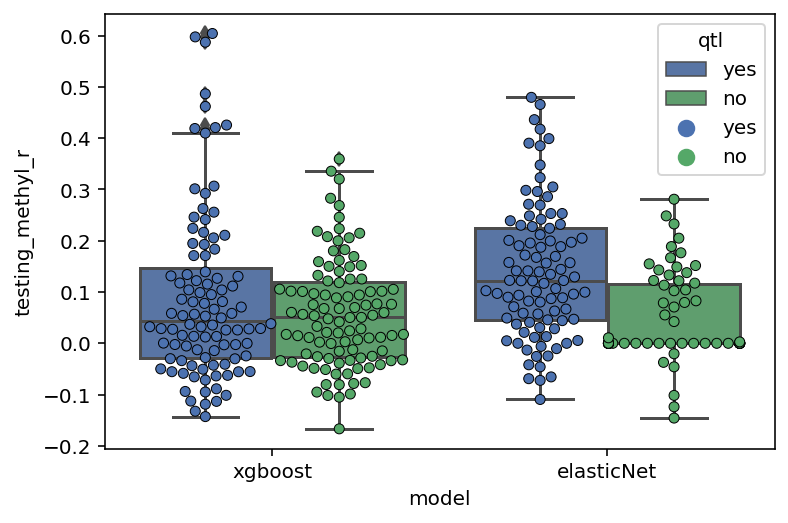

In [27]:
sns.boxplot(data = perf_df, x='model', y='testing_methyl_r', hue='qtl')
# add black edge color
sns.swarmplot(data = perf_df, x='model', y='testing_methyl_r', hue='qtl', dodge=True, edgecolor='black', linewidth=0.5)

<AxesSubplot:xlabel='model', ylabel='testing_methyl_mae'>

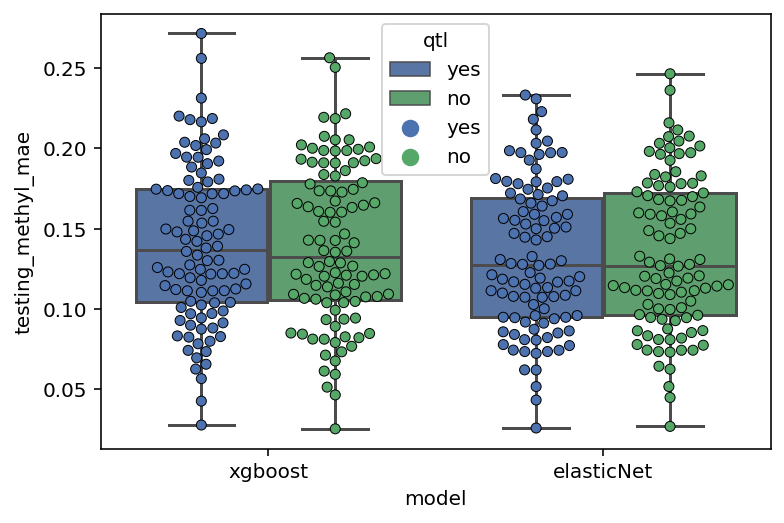

In [28]:
sns.boxplot(data = perf_df, x='model', y='testing_methyl_mae', hue='qtl')
# add black edge color
sns.swarmplot(data = perf_df, x='model', y='testing_methyl_mae', hue='qtl', dodge=True, edgecolor='black', linewidth=0.5)

In [124]:
# what does the best performing elasticNet CpG model look like?
best_elasticNet_cpg = yesqtl_elasticNet.perf_df.sort_values('testing_methyl_r', ascending=False).index[5]
coef_df = pd.DataFrame({'feature_name': yesqtl_elasticNet.trained_models[best_elasticNet_cpg].feature_names_in_, 'coef': yesqtl_elasticNet.trained_models[best_elasticNet_cpg].coef_})
# drop rows with coef == 0
coef_df = coef_df[coef_df['coef'] != 0]
# where is this cpg actually
print(illumina_cpg_locs_df.loc[illumina_cpg_locs_df['#id'] == best_elasticNet_cpg])
print(coef_df)

              #id chr      start Strand
71887  cg09777256   2  179440846      R
                feature_name      coef
4171                  nearby -0.024772
4172      matrixqtl_neg_beta -0.043679
4174  matrixqtl_neg_beta_ext  0.003468


SpearmanrResult(correlation=0.18251535164099683, pvalue=0.02347789848224836)

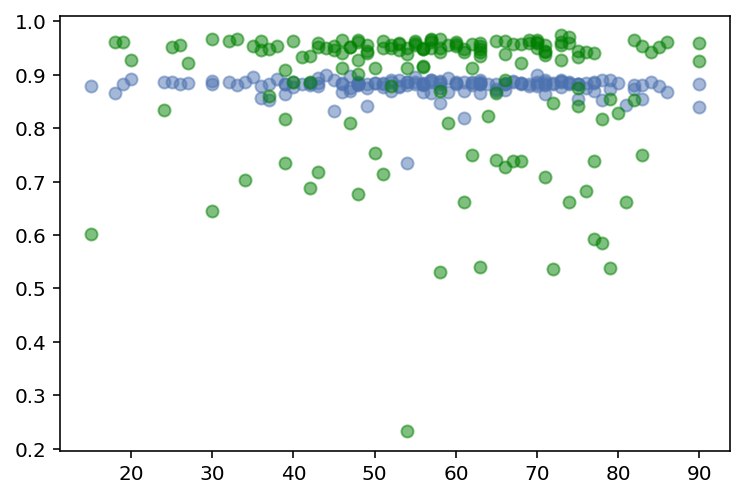

In [125]:
plt.scatter(all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index'],
            yesqtl_elasticNet.pred_df.loc[mut_feat.test_samples, best_elasticNet_cpg], alpha=0.5)
plt.scatter(all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index'],
            all_methyl_age_df_t.loc[mut_feat.test_samples, best_elasticNet_cpg],
            c = 'g', alpha = 0.5)
spearmanr(yesqtl_elasticNet.pred_df.loc[mut_feat.test_samples, best_elasticNet_cpg], all_methyl_age_df_t.loc[mut_feat.test_samples, best_elasticNet_cpg])

/tmp/ipykernel_613811/2785282049.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  yesqtl_elasticNet.mut_feat_store['feat_mats'][best_elasticNet_cpg].loc[mut_feat.test_samples, coef_df['feature_name']].hist(ax=axes)


array([[<AxesSubplot:title={'center':'7:140453137'}>,
        <AxesSubplot:title={'center':'pos_corr_ext'}>,
        <AxesSubplot:title={'center':'neg_corr_ext'}>],
       [<AxesSubplot:title={'center':'nearby'}>,
        <AxesSubplot:title={'center':'matrixqtl_neg_beta'}>,
        <AxesSubplot:title={'center':'matrixqtl_neg_beta_ext'}>],
       [<AxesSubplot:title={'center':'1:115256528-115256778'}>,
        <AxesSubplot:title={'center':'gender_FEMALE'}>,
        <AxesSubplot:title={'center':'gender_MALE'}>]], dtype=object)

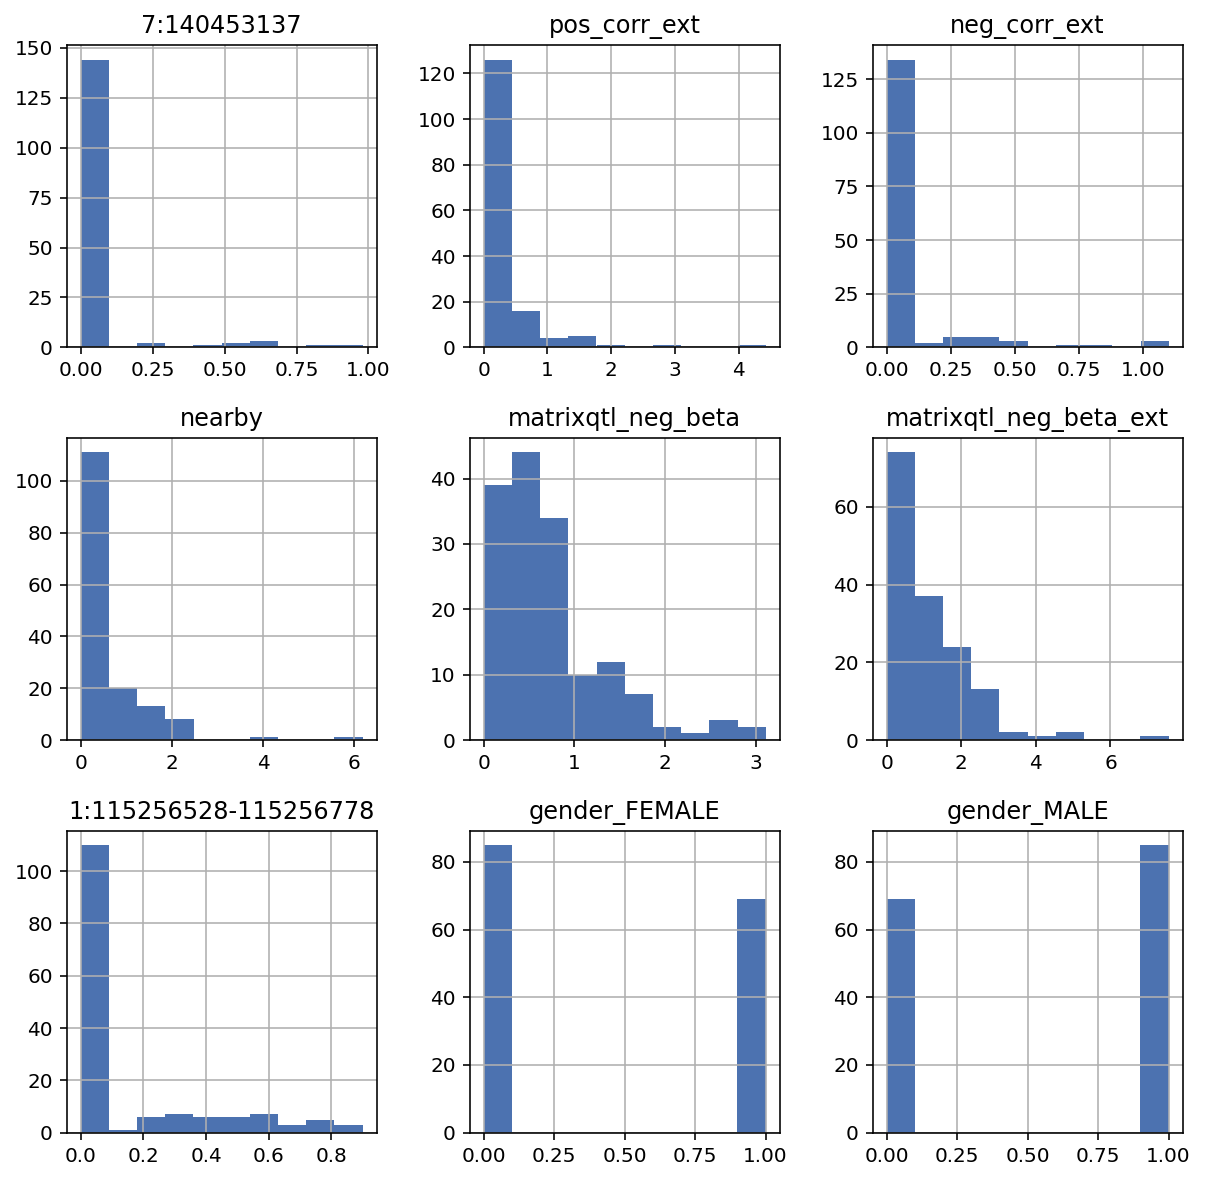

In [92]:
# get feature matrix of testing samples
fig, axes = plt.subplots(figsize=(10, 10))
yesqtl_elasticNet.mut_feat_store['feat_mats'][best_elasticNet_cpg].loc[mut_feat.test_samples, coef_df['feature_name']].hist(ax=axes)

In [110]:
# what does the best performing elasticNet CpG model look like?
best_elasticNet_cpg = noqtl_elasticNet.perf_df.sort_values('testing_methyl_r', ascending=False).index[2]
coef_df = pd.DataFrame({'feature_name': noqtl_elasticNet.trained_models[best_elasticNet_cpg].feature_names_in_, 'coef': noqtl_elasticNet.trained_models[best_elasticNet_cpg].coef_})
# drop rows with coef == 0
coef_df = coef_df[coef_df['coef'] != 0]
# where is this cpg actually
print(illumina_cpg_locs_df.loc[illumina_cpg_locs_df['#id'] == best_elasticNet_cpg])
print(coef_df)

               #id chr      start Strand
150929  cg13283199   5  140552992      F
      feature_name      coef
1714  pos_corr_ext -0.000898


array([[1.        , 0.23269558],
       [0.23269558, 1.        ]])

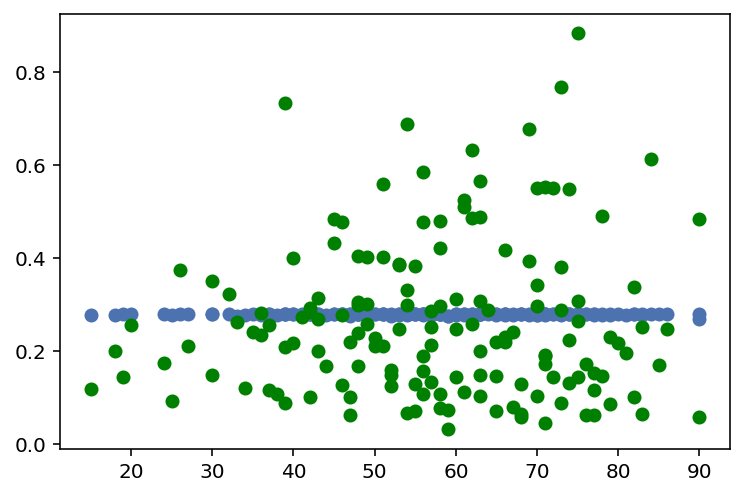

In [111]:
plt.scatter(all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index'],
            noqtl_elasticNet.pred_df.loc[mut_feat.test_samples, best_elasticNet_cpg])
plt.scatter(all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index'],
            all_methyl_age_df_t.loc[mut_feat.test_samples, best_elasticNet_cpg],
            c = 'g')
np.corrcoef(noqtl_elasticNet.pred_df.loc[mut_feat.test_samples, best_elasticNet_cpg], all_methyl_age_df_t.loc[mut_feat.test_samples, best_elasticNet_cpg])

array([<AxesSubplot:title={'center':'pos_corr_ext'}>], dtype=object)

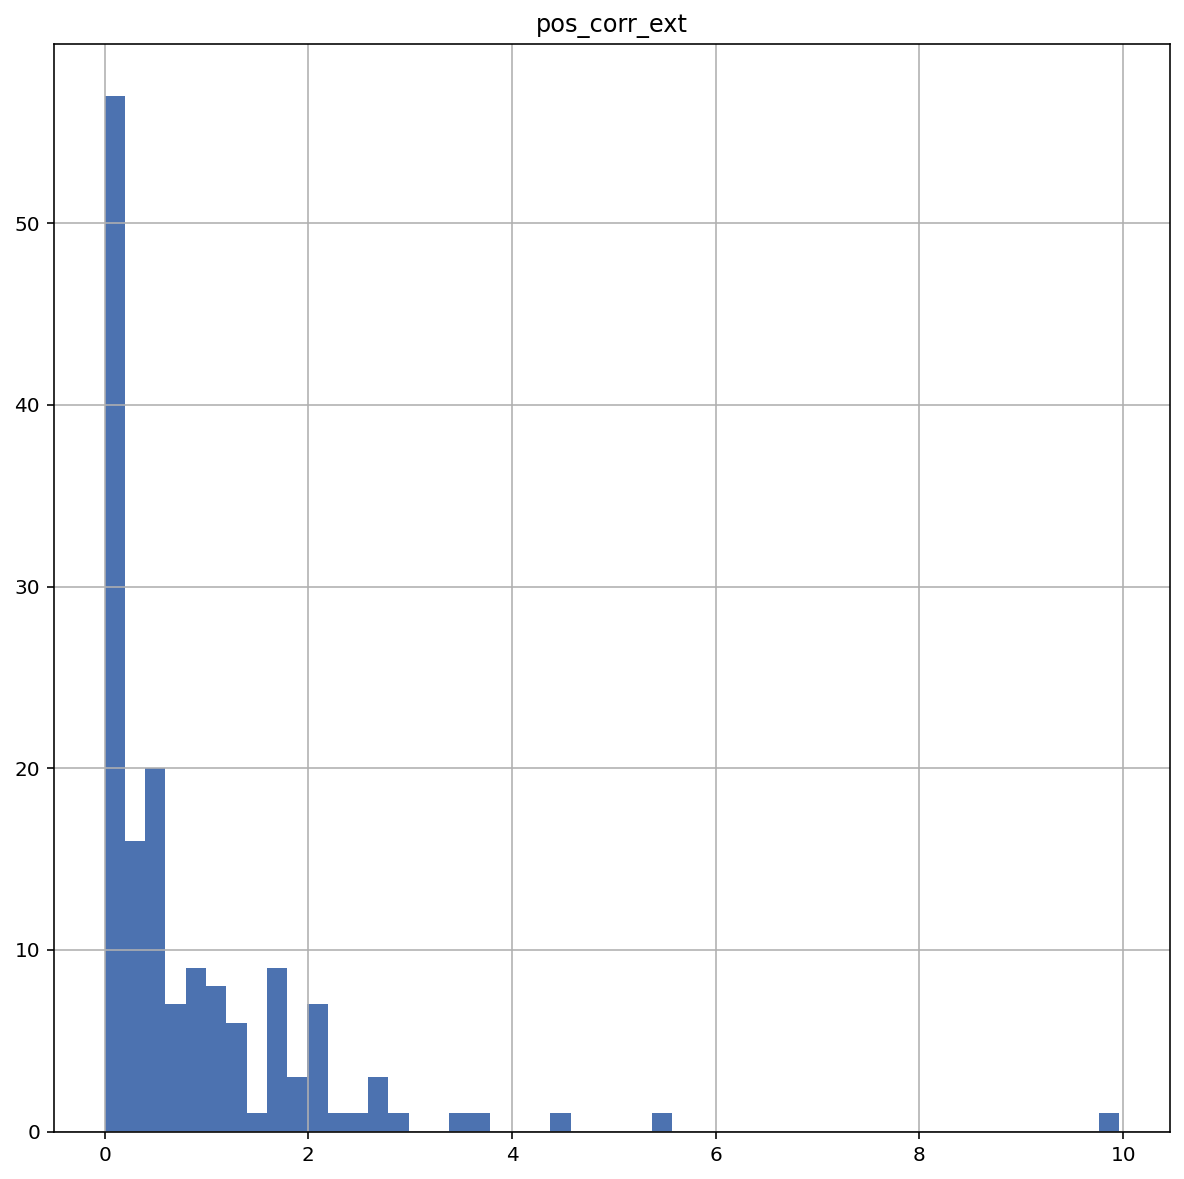

In [97]:
# get feature matrix of testing samples
fig, axes = plt.subplots(figsize=(10, 10))
noqtl_elasticNet.mut_feat_store['feat_mats'][best_elasticNet_cpg].loc[mut_feat.test_samples, coef_df['feature_name']].hist(ax=axes, bins=50)
# set y scale to log

#### How random sites get high matrixQTL pvals

In [248]:
chr1_cpgs = illumina_cpg_locs_df.loc[illumina_cpg_locs_df['chr'] == '1'].sort_values(by='start')
# calculate the distance between every 2 adjacent rows in the dataframe
chr1_cpgs['dist'] = chr1_cpgs['start'].diff()

In [256]:
chr1_cpgs.loc[18748]

#id       cg03887676
chr                1
start      142616241
Strand             F
dist      21131101.0
Name: 18748, dtype: object

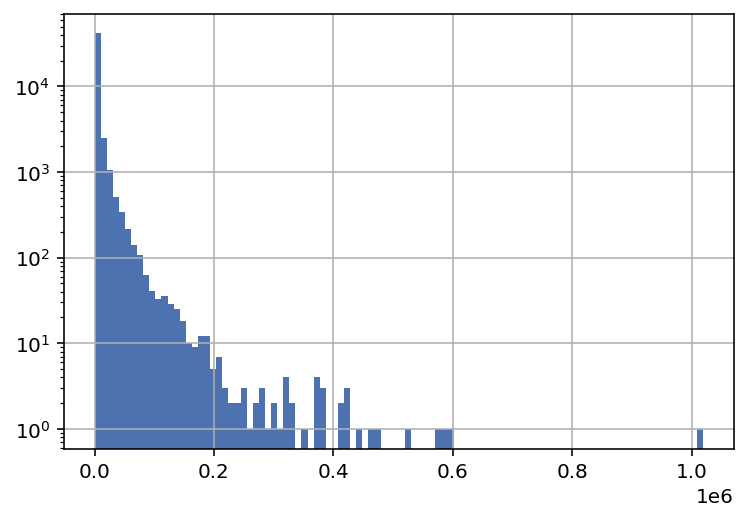

In [257]:
chr1_cpgs['dist'].drop(index = [18748]).hist(bins=100)
plt.yscale('log')

In [ ]:
chr20_matrix_qtl_df = pd.read_parquet(os.path.join("/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/muts", "chr20_meqtl.parquet"))

In [243]:
chr20_matrix_qtl_df.sort_values(by='FDR').head(10)

,SNP,#id,beta,t-stat,p-value,FDR,cpg_chr,cpg_start,snp_chr,snp_start,cis,distance
596,14:105409290,cg16523653,0.991196,42.064040,2.225074e-308,1.891043e-303,20,31350394,14,105409290,False,-1
587,14:20344521,cg16523653,1.608175,57.548826,2.225074e-308,1.891043e-303,20,31350394,14,20344521,False,-1
586,14:106209175,cg16523653,1.464772,71.338762,2.225074e-308,1.891043e-303,20,31350394,14,106209175,False,-1
585,14:20248711,cg16523653,2.140821,71.338762,2.225074e-308,1.891043e-303,20,31350394,14,20248711,False,-1
584,14:106610441,cg16523653,4.638445,71.338762,2.225074e-308,1.891043e-303,20,31350394,14,106610441,False,-1
583,14:105408280,cg16523653,3.478833,71.338762,2.225074e-308,1.891043e-303,20,31350394,14,105408280,False,-1
582,14:104474748,cg16523653,1.637098,71.338762,2.225074e-308,1.891043e-303,20,31350394,14,104474748,False,-1
580,14:20344748,cg26138776,2.380075,71.814798,2.225074e-308,1.891043e-303,20,32273636,14,20344748,False,-1
576,14:105615281,cg18048949,3.069763,72.471998,2.225074e-308,1.891043e-303,20,40247076,14,105615281,False,-1
575,14:105353507,cg18048949,1.491028,72.471998,2.225074e-308,1.891043e-303,20,40247076,14,105353507,False,-1


In [244]:
mut_status = all_mut_w_age_df.loc[all_mut_w_age_df['mut_loc'] == '14:20344748', ['DNA_VAF', 'case_submitter_id', 'mut_loc']]
feat_mat = pd.pivot_table(mut_status, index='case_submitter_id', columns='mut_loc', values='DNA_VAF', fill_value = 0)
feat_mat = feat_mat.reindex(all_methyl_age_df_t.index, fill_value=0)


array([[1.        , 0.47965694],
       [0.47965694, 1.        ]])

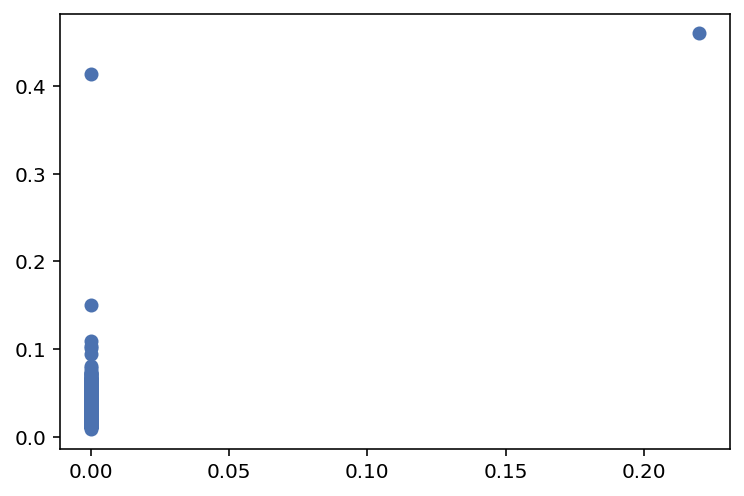

In [246]:
plt.scatter(feat_mat['14:20344748'], all_methyl_age_df_t['cg26138776'])
np.corrcoef(feat_mat['14:20344748'], all_methyl_age_df_t['cg26138776'])

#### Number of repeated mutations

In [7]:
all_mut_w_age_df['mut_loc'] = all_mut_w_age_df['chr'].astype(str) + ':' + all_mut_w_age_df['start'].astype(str)
mut_event_counts = all_mut_w_age_df['mut_loc'].value_counts()

In [8]:
all_mut_w_age_df

,case_submitter_id,chr,start,end,reference,alt,DNA_VAF,mutation,dataset,gender,age_at_index,dataset_r,gender_r,mut_loc
0,TCGA-02-0003,10,123810032,123810032,C,T,0.88,C>T,GBM,MALE,50,GBM,MALE,10:123810032
1,TCGA-02-0003,10,133967449,133967449,C,T,0.79,C>T,GBM,MALE,50,GBM,MALE,10:133967449
2,TCGA-02-0003,11,124489539,124489539,G,A,0.41,G>A,GBM,MALE,50,GBM,MALE,11:124489539
3,TCGA-02-0003,11,47380512,47380512,G,T,0.50,G>T,GBM,MALE,50,GBM,MALE,11:47380512
4,TCGA-02-0003,11,89868837,89868837,C,T,0.51,C>T,GBM,MALE,50,GBM,MALE,11:89868837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907330,TCGA-ZX-AA5X,X,122829875,122829875,T,G,0.10,T>G,CESC,FEMALE,64,CESC,FEMALE,X:122829875
2907331,TCGA-ZX-AA5X,X,129498779,129498779,G,T,0.21,G>T,CESC,FEMALE,64,CESC,FEMALE,X:129498779
2907332,TCGA-ZX-AA5X,X,137714160,137714160,C,T,0.04,C>T,CESC,FEMALE,64,CESC,FEMALE,X:137714160
2907333,TCGA-ZX-AA5X,X,73044379,73044379,C,T,0.10,C>T,CESC,FEMALE,64,CESC,FEMALE,X:73044379


In [216]:
print(f"unique repeated mutations {mut_event_counts[mut_event_counts > 1].shape[0]}")
print(f"total unique mutations {mut_event_counts.shape[0]}")
print(f"% of unique mutations that are repeated {100*mut_event_counts[mut_event_counts > 1].shape[0] / mut_event_counts.shape[0]}")
print(f"total repeated mutation events {mut_event_counts[mut_event_counts > 1].sum()}")
print(f"total mutation events {mut_event_counts.sum()}")
print(f"% of total mutation events that are repeated {100*mut_event_counts[mut_event_counts > 1].sum() / mut_event_counts.sum()}")

unique repeated mutations 240316
total unique mutations 2419081
% of unique mutations that are repeated 9.934185750704502
total repeated mutation events 555968
total mutation events 2734733
% of total mutation events that are repeated 20.3298822956391


In [134]:
cov_fn = "/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/tcga_covariates.csv.gz"


# set number of cross validations
number_of_cvs = 3
cv_num = 0
# get samples and their ages from cov_fn
cov_df = pd.read_csv(cov_fn, header = 0, index_col=0).T

In [140]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=10, shuffle=True)
# get first fold training sampples
for i, (train_index, test_index) in enumerate(skf.split(cov_df.index, cov_df['age_at_index'])):
    if i == 0:
        train_samples = cov_df.iloc[train_index].index.to_list()
        test_samples = cov_df.iloc[test_index].index.to_list()
        break

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


### Student talks prep

In [6]:
mut_feat0 = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, meqtl_db = godmc_meqtls, out_dir = out_dir, 
    consortium = 'TCGA', dataset = 'SKCM', cross_val_num = 0,
    matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/clumped_muts_CV"
    )
mut_feat1 = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, meqtl_db = godmc_meqtls, out_dir = out_dir, 
    consortium = 'TCGA', dataset = 'SKCM', cross_val_num = 1,
    matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/clumped_muts_CV"
    )
mut_feat2 = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, meqtl_db = godmc_meqtls, out_dir = out_dir, 
    consortium = 'TCGA', dataset = 'SKCM', cross_val_num = 2,
    matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/clumped_muts_CV"
    )

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [170]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/030923_output"
string = "TCGA_SKCM_500correl_100000meqtl_50000nearby_Bothagg_500numCpGs_*startTopCpGs_26000maxDBsites_250extendAmount_0crossValNum"
predicted_methyl_fns = glob.glob(os.path.join(out_dir, string, "methyl_predictions_elasticNet_Falsescramble.parquet" ))
predicted_perf_fns = glob.glob(os.path.join(out_dir, string, "prediction_performance_elasticNet_Falsescramble.parquet" ))
trained_models_fns = glob.glob(os.path.join(out_dir, string, "trained_models_elasticNet_Falsescramble.pkl" ))
#
string = "TCGA_SKCM_500correl_100000meqtl_50000nearby_Bothagg_1000numCpGs_*startTopCpGs_26000maxDBsites_250extendAmount_0crossValNum"
predicted_methyl_fns2 = glob.glob(os.path.join(out_dir, string, "methyl_predictions_elasticNet_Falsescramble.parquet" ))
predicted_perf_fns2 = glob.glob(os.path.join(out_dir, string, "prediction_performance_elasticNet_Falsescramble.parquet" )) 
trained_models_fns2 = glob.glob(os.path.join(out_dir, string, "trained_models_elasticNet_Falsescramble.pkl" ))

predicted_methyl_fns = predicted_methyl_fns + predicted_methyl_fns2
predicted_perf_fns = predicted_perf_fns + predicted_perf_fns2
trained_models_fns = trained_models_fns + trained_models_fns2

soMage0 = somatic_mut_clock.mutationClock(
        predicted_methyl_fns = predicted_methyl_fns, 
        predicted_perf_fns = predicted_perf_fns,
        all_methyl_age_df_t = all_methyl_age_df_t,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        output_dir = out_dir,
        train_samples = mut_feat0.train_samples,
        test_samples = mut_feat0.test_samples,
        tissue_type = "SKCM",
        trained_models_fns = trained_models_fns)

"""# same for CV 1
string = "TCGA_SKCM_500correl_100000meqtl_50000nearby_Bothagg_500numCpGs_*startTopCpGs_26000maxDBsites_250extendAmount_1crossValNum"
predicted_methyl_fns = glob.glob(os.path.join(out_dir, string, "methyl_predictions_elasticNet_Falsescramble.parquet" ))
predicted_perf_fns = glob.glob(os.path.join(out_dir, string, "prediction_performance_elasticNet_Falsescramble.parquet" ))
soMage1 = somatic_mut_clock.mutationClock(
        predicted_methyl_fns = predicted_methyl_fns, 
        predicted_perf_fns = predicted_perf_fns,
        all_methyl_age_df_t = all_methyl_age_df_t,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        output_dir = out_dir,
        train_samples = mut_feat1.train_samples,
        test_samples = mut_feat1.test_samples,
        tissue_type = "SKCM")

# same for CV 2
string = "TCGA_SKCM_500correl_100000meqtl_50000nearby_Bothagg_500numCpGs_*startTopCpGs_26000maxDBsites_250extendAmount_2crossValNum"
predicted_methyl_fns = glob.glob(os.path.join(out_dir, string, "methyl_predictions_elasticNet_Falsescramble.parquet" ))
predicted_perf_fns = glob.glob(os.path.join(out_dir, string, "prediction_performance_elasticNet_Falsescramble.parquet" ))
soMage2 = somatic_mut_clock.mutationClock(
        predicted_methyl_fns = predicted_methyl_fns, 
        predicted_perf_fns = predicted_perf_fns,
        all_methyl_age_df_t = all_methyl_age_df_t,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        output_dir = out_dir,
        train_samples = mut_feat2.train_samples,
        test_samples = mut_feat2.test_samples,
        tissue_type = "SKCM")"""

'# same for CV 1\nstring = "TCGA_SKCM_500correl_100000meqtl_50000nearby_Bothagg_500numCpGs_*startTopCpGs_26000maxDBsites_250extendAmount_1crossValNum"\npredicted_methyl_fns = glob.glob(os.path.join(out_dir, string, "methyl_predictions_elasticNet_Falsescramble.parquet" ))\npredicted_perf_fns = glob.glob(os.path.join(out_dir, string, "prediction_performance_elasticNet_Falsescramble.parquet" ))\nsoMage1 = somatic_mut_clock.mutationClock(\n        predicted_methyl_fns = predicted_methyl_fns, \n        predicted_perf_fns = predicted_perf_fns,\n        all_methyl_age_df_t = all_methyl_age_df_t,\n        illumina_cpg_locs_df = illumina_cpg_locs_df,\n        output_dir = out_dir,\n        train_samples = mut_feat1.train_samples,\n        test_samples = mut_feat1.test_samples,\n        tissue_type = "SKCM")\n\n# same for CV 2\nstring = "TCGA_SKCM_500correl_100000meqtl_50000nearby_Bothagg_500numCpGs_*startTopCpGs_26000maxDBsites_250extendAmount_2crossValNum"\npredicted_methyl_fns = glob.glob(os.

In [173]:
soMage0._populate_performance()
"""soMage1._populate_performance()
soMage2._populate_performance()"""

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


'soMage1._populate_performance()\nsoMage2._populate_performance()'

#### Analyze best performing CpGS

Text(0.5, 0, 'Spearman R (Actual vs. Predicted Methylation)')

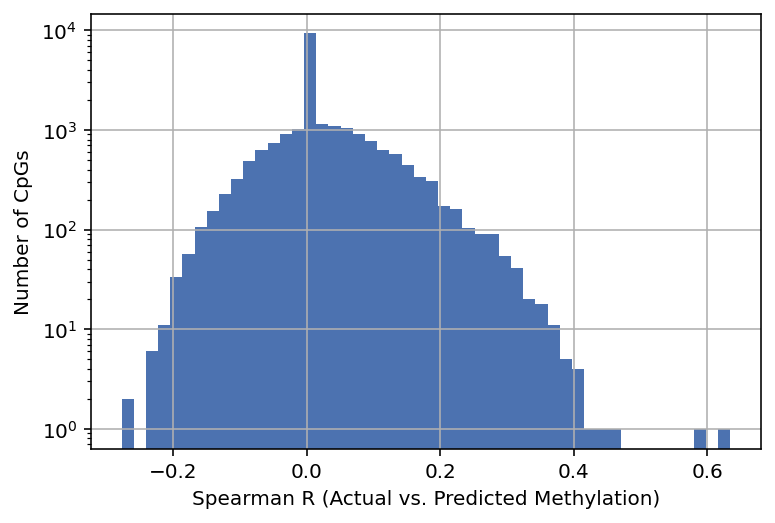

In [90]:
soMage0.performance_df.testing_methyl_spearmanr.hist(bins = 50)
plt.yscale("log")
plt.ylabel("Number of CpGs")
plt.xlabel("Spearman R (Actual vs. Predicted Methylation)")

In [263]:
soMage0.performance_df.merge(illumina_cpg_locs_df, left_index = True, right_on = "#id").sort_values("training_pred_mf_age_spearmanr", ascending = False).head(250)[['training_pred_real_mf_r', 'training_pred_real_mf_spearmanr', 'testing_methyl_spearmanr', 'training_pred_mf_age_pearsonr', 'testing_pred_mf_age_pearsonr', '#id', 'chr', 'start']]


,training_pred_real_mf_r,training_pred_real_mf_spearmanr,testing_methyl_spearmanr,training_pred_mf_age_pearsonr,testing_pred_mf_age_pearsonr,#id,chr,start
209963,0.354999,0.277123,0.163908,0.301201,0.263507,cg08571362,7,100224015
203087,0.248283,0.201543,-0.019093,0.334525,0.305310,cg02579509,7,107302712
201078,0.489444,0.307584,0.028892,0.283820,0.248502,cg00921574,7,1513873
226644,0.296902,0.254311,0.154311,0.347953,0.304413,cg24681654,7,31555516
214549,0.193022,0.166946,0.037575,0.327419,0.315219,cg12967723,7,100464145
...,...,...,...,...,...,...,...,...
211862,0.179050,0.196865,0.041825,0.234080,0.292362,cg10308629,7,134354803
454303,0.462131,0.279109,-0.047488,0.135228,-0.037349,cg19332452,19,12936719
463396,0.174543,0.180048,0.057481,0.187007,0.024107,cg02133557,20,61560434
191440,0.306219,0.295202,0.282731,0.211776,0.196505,cg21085190,6,26235254


In [211]:
all_mut_w_age_df.loc[all_mut_w_age_df['case_submitter_id'].isin(soMage0.train_samples), 'mut_loc'].value_counts().head(10)

7:140453136    132
1:115256529     45
7:140453137     29
1:115256530     25
7:56174183      24
8:125551344     14
8:125551345     12
19:50169131     12
9:130700157     11
14:63453898     11
Name: mut_loc, dtype: int64

In [190]:
def get_model_coefs(model):
    coef_df = pd.DataFrame({"coef": model.coef_[model.coef_!=0], "feat_name": model.feature_names_in_[model.coef_!=0]})
    return coef_df

def scatter_pred_vs_real(cpg_name):
    plt.scatter(all_methyl_age_df_t.loc[soMage0.test_samples, 'age_at_index'], soMage0.predicted_methyl_df.loc[soMage0.test_samples, cpg_name], c = "blue", alpha = 0.8, label = "Predicted")
    # actual
    plt.scatter(all_methyl_age_df_t.loc[soMage0.test_samples, 'age_at_index'], all_methyl_age_df_t.loc[soMage0.test_samples, cpg_name], c = "red", alpha = 0.8, label = "Actual")
    plt.legend()

,coef,feat_name
0,-0.135416,7:140453136
1,0.016427,7:140453137
2,0.016647,neg_corr_ext
3,0.015339,matrixqtl_neg_beta_ext
4,0.009293,matrixqtl_neg_beta_close_ext


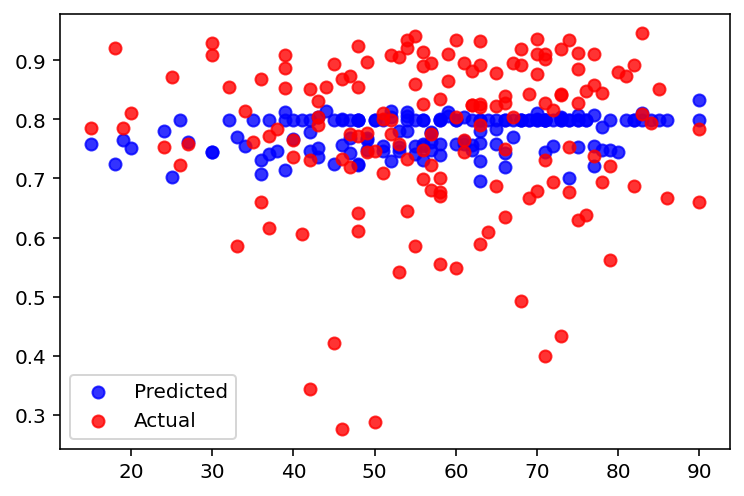

In [257]:
c = 'cg02579509'
coef_df = get_model_coefs(soMage0.trained_models[c])
scatter_pred_vs_real(c)
coef_df

#### Build clock

5 SpearmanrResult(correlation=0.28893086210734087, pvalue=0.000292182735466041)
5 (0.29663785627120576, 0.00019665333799739063)


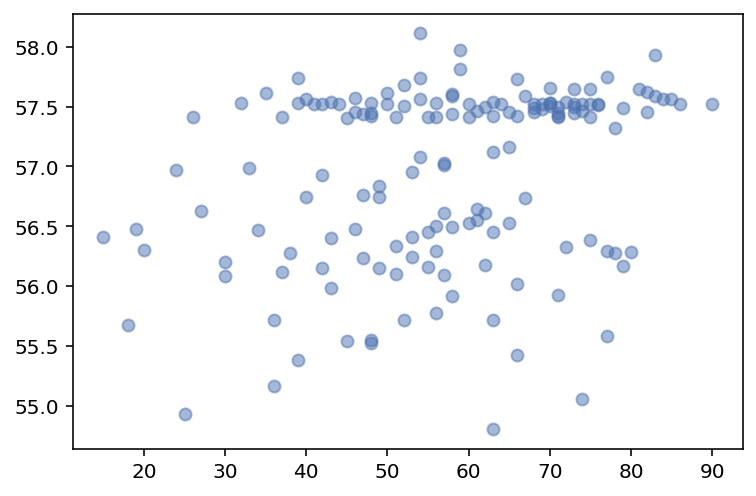

In [274]:
# training_pred_real_mf_r: sorting by how well the training methylation is predicted
# training_pred_mf_age_r: sorting by how well the training age-crr is predicted [BEST .3  for pearson and spearman]
# training_pred_mf_age_spearmanr: same but spearman [ALSO BEST .3 for pearson and spearman]
# training_real_mf_age_r: sorting by the real training agec-corr
soMage0.performance_df.sort_values("training_pred_mf_age_spearmanr", ascending = False, inplace = True)
for num_cpgs in [5]:
    # train a clock on the best performing features
    chosen_cpgs = soMage0.performance_df.index[:50].to_list()
    #chosen_cpgs += soMage0.performance_df.index[250:251].to_list()
    clock_training_samples = soMage0.test_samples
    # drop 'TCGA-FR-A726' from training samples
    clock_training_samples = [x for x in clock_training_samples if x != 'TCGA-FR-A726']
    # create traiing matrices
    X = soMage0.all_methyl_age_df_t.loc[clock_training_samples, chosen_cpgs]
    y = soMage0.all_methyl_age_df_t.loc[clock_training_samples, "age_at_index"]
    # train clock
    soMage0_clock = soMage0.train_epi_clock(X, y)
    # apply clock to predicted methylation data
    preds0 = soMage0.apply_epi_clock(X = soMage0.predicted_methyl_df.loc[clock_training_samples, chosen_cpgs], model = soMage0_clock)
    print(num_cpgs, spearmanr(y, preds0))
    print(num_cpgs, pearsonr(y, preds0))
    
    plt.scatter(y, preds0, alpha=0.5)
    # plot y = x line
    #plt.plot([15, 85], [15, 85], color='red', lw=3, zorder=0)

In [119]:
all_mut_w_age_df

,case_submitter_id,chr,start,end,reference,alt,DNA_VAF,mutation,dataset,gender,age_at_index,dataset_r,gender_r
0,TCGA-02-0003,10,123810032,123810032,C,T,0.88,C>T,GBM,MALE,50,GBM,MALE
1,TCGA-02-0003,10,133967449,133967449,C,T,0.79,C>T,GBM,MALE,50,GBM,MALE
2,TCGA-02-0003,11,124489539,124489539,G,A,0.41,G>A,GBM,MALE,50,GBM,MALE
3,TCGA-02-0003,11,47380512,47380512,G,T,0.50,G>T,GBM,MALE,50,GBM,MALE
4,TCGA-02-0003,11,89868837,89868837,C,T,0.51,C>T,GBM,MALE,50,GBM,MALE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907330,TCGA-ZX-AA5X,X,122829875,122829875,T,G,0.10,T>G,CESC,FEMALE,64,CESC,FEMALE
2907331,TCGA-ZX-AA5X,X,129498779,129498779,G,T,0.21,G>T,CESC,FEMALE,64,CESC,FEMALE
2907332,TCGA-ZX-AA5X,X,137714160,137714160,C,T,0.04,C>T,CESC,FEMALE,64,CESC,FEMALE
2907333,TCGA-ZX-AA5X,X,73044379,73044379,C,T,0.10,C>T,CESC,FEMALE,64,CESC,FEMALE


In [129]:
set(clock_training_samples) - set(all_mut_w_age_df.loc[all_mut_w_age_df['case_submitter_id'].isin(clock_training_samples), 'case_submitter_id'].value_counts().index) 

{'TCGA-DA-A3F2'}

In [136]:
all_methyl_age_df_t.loc['TCGA-FR-A726', 'age_at_index']

90

In [135]:
all_mut_w_age_df.loc[all_mut_w_age_df['case_submitter_id'].isin(clock_training_samples), 'case_submitter_id'].value_counts()

TCGA-FR-A726    10147
TCGA-GF-A6C9     3854
TCGA-EE-A29M     3247
TCGA-EE-A3JD     3102
TCGA-EE-A20C     2873
                ...  
TCGA-EB-A4IQ       22
TCGA-XV-A9VZ       18
TCGA-EB-A4OZ       16
TCGA-DA-A1IB        9
TCGA-D3-A8GE        8
Name: case_submitter_id, Length: 153, dtype: int64

100 SpearmanrResult(correlation=0.29249110939846407, pvalue=0.00023234060657150205)


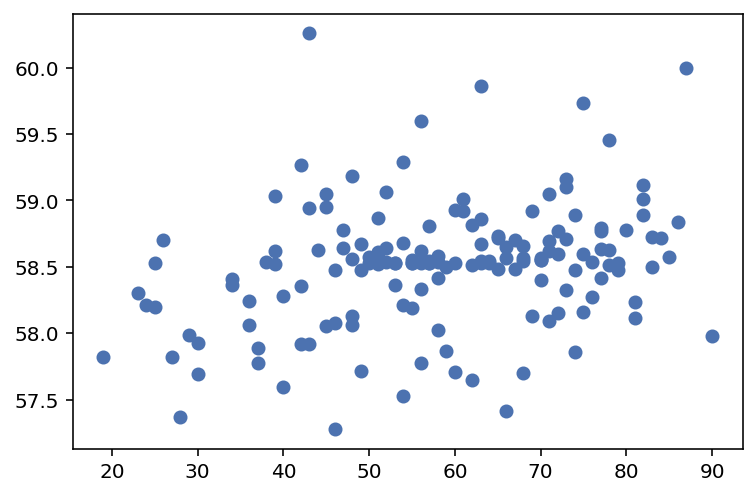

In [491]:
soMage1.performance_df['abs_training_pred_mf_age_r'] = soMage1.performance_df.training_pred_mf_age_r.abs()
soMage1.performance_df.sort_values("abs_training_pred_mf_age_r", ascending = False, inplace = True)
for num_cpgs in [100]:
    # train a clock on the best performing features
    chosen_cpgs = soMage1.performance_df.index[:num_cpgs]
    clock_training_samples = soMage1.test_samples
    # create traiing matrices
    X = soMage1.all_methyl_age_df_t.loc[clock_training_samples, chosen_cpgs]
    y = soMage1.all_methyl_age_df_t.loc[clock_training_samples, "age_at_index"]
    # train clock
    soMage1_clock = soMage1.train_epi_clock(X, y)
    # apply clock to predicted methylation data
    preds1 = soMage1.apply_epi_clock(X = soMage1.predicted_methyl_df.loc[clock_training_samples, chosen_cpgs],model = soMage1_clock)
    print(num_cpgs, spearmanr(y, preds1))
    plt.scatter(y, preds1)
    

100 SpearmanrResult(correlation=0.24364620092883704, pvalue=0.002327120155905764)


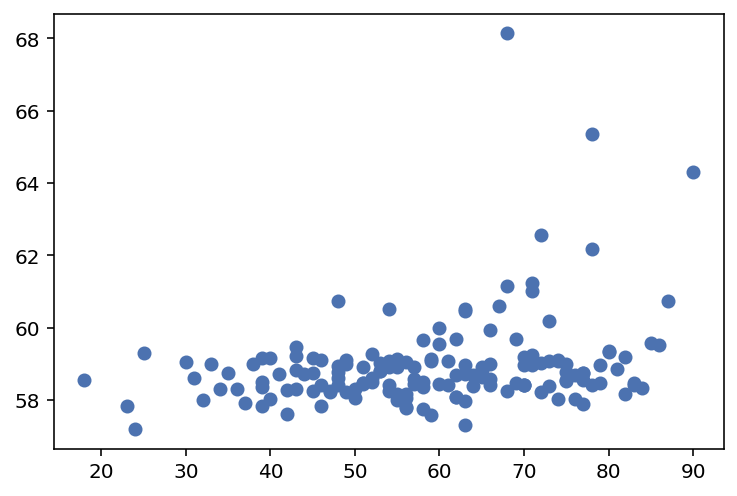

In [505]:
soMage2.performance_df['abs_training_pred_mf_age_r'] = soMage2.performance_df.training_pred_mf_age_r.abs()
soMage2.performance_df.sort_values("abs_training_pred_mf_age_r", ascending = False, inplace = True)
for num_cpgs in [100]:
    # train a clock on the best performing features
    chosen_cpgs = soMage2.performance_df.index[:num_cpgs]
    clock_training_samples = soMage2.test_samples
    # create traiing matrices
    X = soMage2.all_methyl_age_df_t.loc[clock_training_samples, chosen_cpgs]
    y = soMage2.all_methyl_age_df_t.loc[clock_training_samples, "age_at_index"]
    # train clock
    soMage2_clock = soMage2.train_epi_clock(X, y)
    # apply clock to predicted methylation data
    preds2 = soMage1.apply_epi_clock(X = soMage2.predicted_methyl_df.loc[clock_training_samples, chosen_cpgs],model = soMage2_clock)
    print(num_cpgs, spearmanr(y, preds2))
    plt.scatter(y, preds2)
    

(0.11108135927423096, 4.860390714724141e-39)

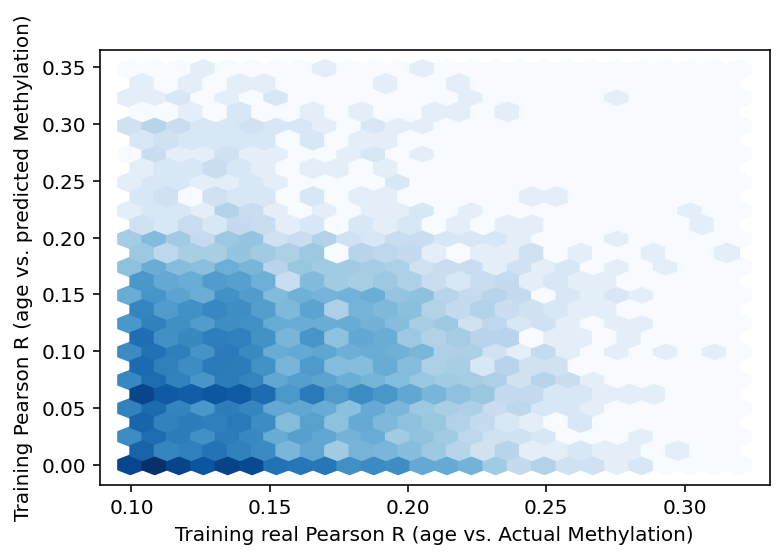

In [98]:
# real age correlation of CpGs in training vs predicted age corr in training
plt.hexbin(soMage0.performance_df.training_real_mf_age_r.abs(), soMage0.performance_df.training_pred_mf_age_r.abs(), gridsize=25, cmap='Blues', bins='log')
plt.ylabel("Training Pearson R (age vs. predicted Methylation)")
plt.xlabel("Training real Pearson R (age vs. Actual Methylation)")
pearsonr(soMage0.performance_df.dropna().training_real_mf_age_r.abs(), soMage0.performance_df.dropna().training_pred_mf_age_r.abs())


(0.15816326991542665, 8.633428538649689e-78)

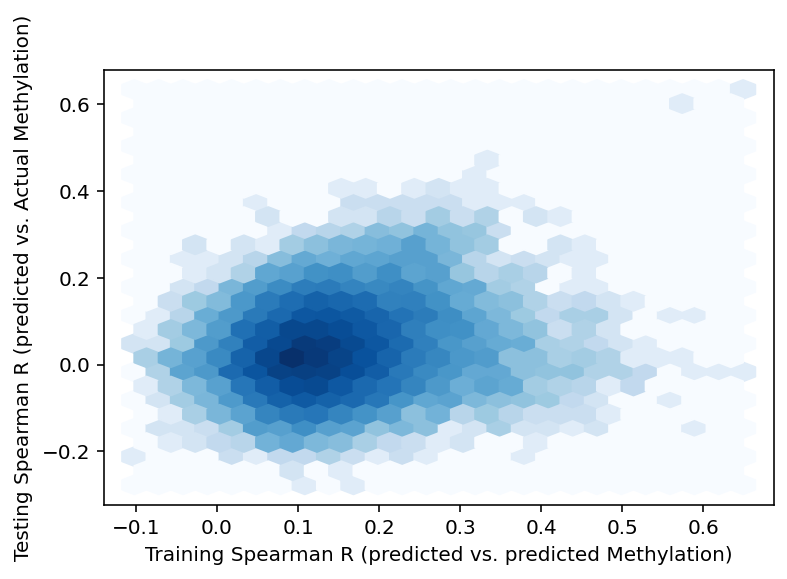

In [108]:
# predicted vs actual methylation in training vs in testing, spearman
plt.hexbin(soMage0.performance_df.training_pred_real_mf_spearmanr, soMage0.performance_df.testing_methyl_spearmanr, gridsize=25, cmap='Blues', bins='log')
plt.xlabel("Training Spearman R (predicted vs. predicted Methylation)")
plt.ylabel("Testing Spearman R (predicted vs. Actual Methylation)")
pearsonr(soMage0.performance_df.dropna().training_pred_real_mf_spearmanr, soMage0.performance_df.dropna().testing_methyl_spearmanr)


SpearmanrResult(correlation=0.2384497775345504, pvalue=3.500353203962059e-177)

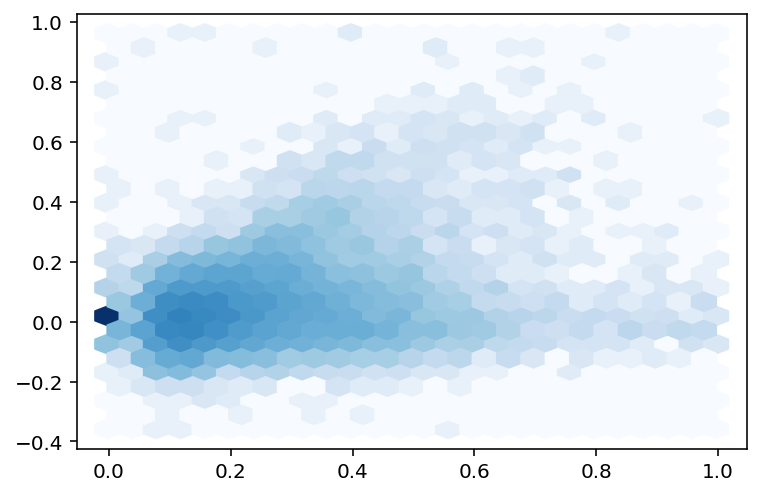

In [106]:
# predicted vs actual methylation in training vs in testing, oerason
plt.hexbin(soMage0.performance_df.training_pred_real_mf_r, soMage0.performance_df.testing_methyl_pearsonr, gridsize=25, cmap='Blues', bins='log')
spearmanr(soMage0.performance_df.dropna().training_pred_real_mf_r, soMage0.performance_df.dropna().testing_methyl_pearsonr)

SpearmanrResult(correlation=0.022714874508857254, pvalue=0.007702979142470157)

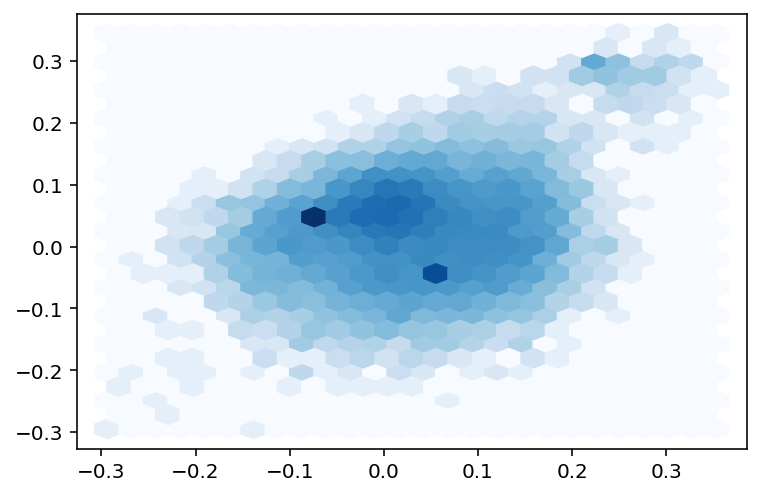

In [104]:
plt.hexbin(soMage0.performance_df['training_pred_mf_age_spearmanr'], soMage0.performance_df['testing_pred_mf_age_spearmanr'], gridsize=25, cmap='Blues', bins='log')
spearmanr(soMage0.performance_df.dropna()['training_pred_mf_age_spearmanr'], soMage0.performance_df.dropna()['testing_pred_mf_age_spearmanr'])